## Preparation (40 points total)
### [20 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.preprocessing import sequence

raw_df = pd.read_csv('./south-park-dialogue/All-seasons.csv')

Using TensorFlow backend.


In [2]:
all_classes = raw_df['Character'].values
df = pd.DataFrame(raw_df.drop(['Character', 'Season', 'Episode'], axis=1).values, index=raw_df['Character'], columns=['Line'])

uniques, counts = np.unique(all_classes, return_counts=True)
num_classes = len(uniques)

to_delete = []
names_to_delete = []

character_line_minimum = 100

for i, idx in enumerate(counts):
    if idx < character_line_minimum:
        names_to_delete.append(uniques[i])
    
print("Removing all characters with less than", character_line_minimum, "lines")
print("Total Characters to Remove:",len(names_to_delete))
print("Total Characters Left: ",len(uniques) - len(names_to_delete))

df = df.drop(names_to_delete, axis=0)

new_uniques, y_ints, counts = np.unique(df.index.values, return_inverse=True,return_counts=True)
num_classes = len(new_uniques)
print("Leftover Classes:")
print(new_uniques)

X_preprep = df['Line'].values
y_values = df.index.values

Removing all characters with less than 100 lines
Total Characters to Remove: 3885
Total Characters Left:  65
Leftover Classes:
['Announcer' 'Barbrady' 'Bebe' 'Butters' 'Cartman' 'Chef' 'Chris' 'Clerk'
 'Clyde' 'Coon' 'Craig' 'Crowd' 'Doctor' 'Dr. Doctor' 'General' 'Gerald'
 'Ike' 'Jesus' 'Jimbo' 'Jimmy' 'Kenny' 'Kids' 'Kyle' 'Liane' 'Linda' 'Man'
 'Man 1' 'Man 2' 'Mark' 'Mayor' 'Mayor McDaniels' 'Mephesto' 'Michael'
 'Mr. Garrison' 'Mr. Hankey' 'Mr. Mackey' 'Mrs. Garrison' 'Ms. Choksondik'
 'Mysterion' 'Narrator' 'Ned' 'Officer Barbrady' 'Pete' 'Phillip' 'Pip'
 'Principal Victoria' 'Randy' 'Reporter' 'Satan' 'Scott' 'Sharon' 'Sheila'
 'Shelly' 'Stan' 'Stephen' 'Stuart' 'Terrance' 'The Boys' 'Timmy' 'Token'
 'Towelie' 'Tweek' 'Wendy' 'Woman' 'Yates']


In [3]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = None
padding = 100

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X_preprep)
sequences = tokenizer.texts_to_sequences(X_preprep)

X = pad_sequences(sequences, maxlen=padding)


In [4]:
embeddings_index = {}
word_index = tokenizer.word_index
embed_size = 100

f = open('glove.6B/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((len(word_index) + 1, embed_size))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### [10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.


### [10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_ints, test_size=0.2, stratify=y_values, random_state=8)

y_train_ohe = keras.utils.to_categorical(y_train, num_classes)



## Modeling (50 points total)
### [25 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Adjust hyper-parameters of the networks as needed to improve generalization performance. 

In [6]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            embed_size,
                            weights=[embedding_matrix],
                            input_length=padding,
                            trainable=False)

In [7]:
%%time
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

lstm_rnn = Sequential()
lstm_rnn.add(embedding_layer)
lstm_rnn.add(LSTM(128, dropout=.2, recurrent_dropout=.2))
lstm_rnn.add(Dense(num_classes, activation='sigmoid'))

lstm_rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(lstm_rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1966100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 65)                8385      
Total params: 2,091,733
Trainable params: 125,633
Non-trainable params: 1,966,100
_________________________________________________________________
None
Wall time: 875 ms


In [8]:
lstm_rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=64)

Train on 37396 samples, validate on 9349 samples
Epoch 1/10
37396/37396 [==============================] - 115s - loss: 3.0130 - acc: 0.2085 - val_loss: 2.9559 - val_acc: 0.2091
Epoch 2/10
37396/37396 [==============================] - 125s - loss: 2.9032 - acc: 0.2189 - val_loss: 2.8520 - val_acc: 0.2265
Epoch 3/10
37396/37396 [==============================] - 142s - loss: 2.8238 - acc: 0.2342 - val_loss: 2.7870 - val_acc: 0.2459
Epoch 4/10
37396/37396 [==============================] - 149s - loss: 2.7599 - acc: 0.2501 - val_loss: 2.7578 - val_acc: 0.2624
Epoch 5/10
37396/37396 [==============================] - 149s - loss: 2.7062 - acc: 0.2629 - val_loss: 2.6956 - val_acc: 0.2724
Epoch 6/10
37396/37396 [==============================] - 140s - loss: 2.6513 - acc: 0.2740 - val_loss: 2.6660 - val_acc: 0.2777
Epoch 7/10
37396/37396 [==============================] - 139s - loss: 2.6090 - acc: 0.2864 - val_loss: 2.6384 - val_acc: 0.2854
Epoch 8/10
37396/37396 [========================

In [9]:
from keras.layers import GRU

gru_rnn = Sequential()
gru_rnn.add(embedding_layer)
gru_rnn.add(GRU(128, dropout=.2, recurrent_dropout=.2))
gru_rnn.add(Dense(num_classes, activation='sigmoid'))

gru_rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(gru_rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1966100   
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               87936     
_________________________________________________________________
dense_2 (Dense)              (None, 65)                8385      
Total params: 2,062,421
Trainable params: 96,321
Non-trainable params: 1,966,100
_________________________________________________________________
None


In [10]:
gru_rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=64)

Train on 37396 samples, validate on 9349 samples
Epoch 1/10
37396/37396 [==============================] - 101s - loss: 3.0059 - acc: 0.2082 - val_loss: 2.9191 - val_acc: 0.2091
Epoch 2/10
37396/37396 [==============================] - 100s - loss: 2.8661 - acc: 0.2165 - val_loss: 2.8261 - val_acc: 0.2263
Epoch 3/10
37396/37396 [==============================] - 100s - loss: 2.7721 - acc: 0.2423 - val_loss: 2.7404 - val_acc: 0.2554
Epoch 4/10
37396/37396 [==============================] - 105s - loss: 2.6931 - acc: 0.2675 - val_loss: 2.7075 - val_acc: 0.2708
Epoch 5/10
37396/37396 [==============================] - 100s - loss: 2.6309 - acc: 0.2828 - val_loss: 2.6369 - val_acc: 0.2844
Epoch 6/10
37396/37396 [==============================] - 100s - loss: 2.5856 - acc: 0.2902 - val_loss: 2.6055 - val_acc: 0.2907
Epoch 7/10
37396/37396 [==============================] - 108s - loss: 2.5478 - acc: 0.2990 - val_loss: 2.5862 - val_acc: 0.2939
Epoch 8/10
37396/37396 [========================

In [44]:
from sklearn.metrics import confusion_matrix

lstm_yhat_probs = lstm_rnn.predict(X_test)
lstm_yhat = np.argmax(lstm_yhat_probs, axis=1)

gru_yhat_probs = gru_rnn.predict(X_test)
gru_yhat = np.argmax(gru_yhat_probs, axis=1)

In [45]:
lstm_conf = confusion_matrix(y_test, lstm_yhat)
gru_conf = confusion_matrix(y_test, gru_yhat)

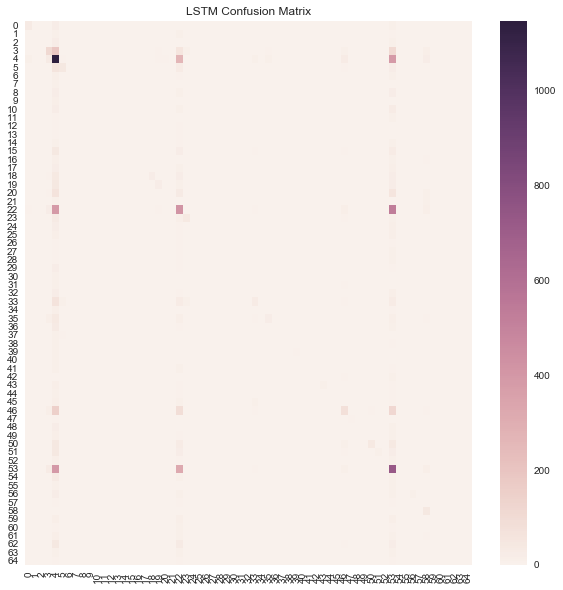

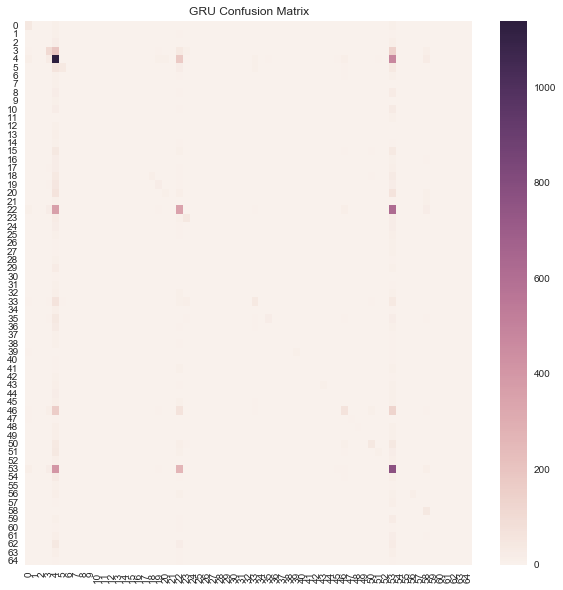

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('LSTM Confusion Matrix')
sns.heatmap(lstm_conf, ax=ax)

fig, ax = plt.subplots(figsize=(10, 10))
plt.title('GRU Confusion Matrix')
sns.heatmap(gru_conf, ax=ax)

In [50]:
new_uniques[4]     #Cartman - Pretty Accurate
new_uniques[53]    #Stan    - Pretty Accurate
new_uniques[22]    #Kyle    - Gets confused for Stan a lot

'Kyle'

In [11]:
def data_prep(words):
    tokened = np.array(tokenizer.texts_to_sequences(words))
    return pad_sequences(tokened, maxlen=padding)

sent = ['Respect my authority']
# print(gru_rnn.predict(data_prep(sent)))
guess = np.argmax(gru_rnn.predict(data_prep(sent)))
new_uniques[guess]

'Cartman'

## Exceptional Work (10 points total)
You have free reign to provide additional analyses.
### One idea: Use more than a single chain of LSTMs or GRUs (i.e., use multiple parallel chains). 
Another Idea: Try to create a RNN for generating novel text. 